In [2]:
using Distributions
using Random
using Statistics
using PoissonRandom
using ArgCheck
using QuadGK
using RunStatistics
using RunStatistics: t_obs

#include("MADMAX-runs.ipynb")


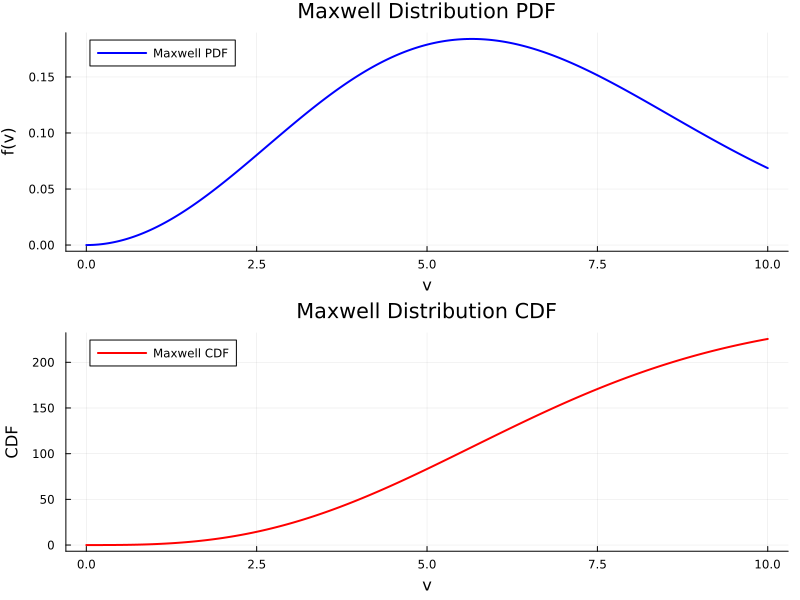

In [ ]:
using Plots, QuadGK

# Maxwell PDF (manually defined)
function maxwell_pdf(v, w)
    v < 0 && return 0.0
    return  (v^2 / w^3) * exp(-v^2 / (2 * w^2))
end

# Normalize for plotting
function maxwell_cdf(v, w)
    v < 0 && return 0.0
    integral, _ = quadgk(x -> A*maxwell_pdf(x, w), 0, v)
    return integral
end

# Parameters
A=20
w = 4.0
x = range(0, stop=10.0, length=1000)

# Compute values
pdf_vals = [maxwell_pdf(xi, w) for xi in x]
cdf_vals = [maxwell_cdf(xi, w) for xi in x]

# Plot PDF and CDF
p1 = plot(x, pdf_vals, lw=2, label="Maxwell PDF", color=:blue)
xlabel!("v"); ylabel!("f(v)"); title!("Maxwell Distribution PDF")

p2 = plot(x, cdf_vals, lw=2, label="Maxwell CDF", color=:red)
xlabel!("v"); ylabel!("CDF"); title!("Maxwell Distribution CDF")

plot(p1, p2, layout=(2, 1), size=(800, 600))


# Maxwell Boltzmann

In [3]:
#
# Same as before, but we now use a Lorentzian instead of a Gaussian for the signal shape
#

# Run multiple tests
n_tests = 1000
nbins = 10000

# Squares Statistic settings
Ns1 = zeros(2); Ns1[1] = 50; Ns1[2] = Int(nbins / Ns1[1])
Ns2 = zeros(2); Ns2[1] = 50; Ns2[2] = Int(nbins / 2 / Ns2[1])
Ns5 = zeros(2); Ns5[1] = 50; Ns5[2] = Int(nbins / 5 / Ns5[1])
Ns10 = zeros(2); Ns10[1] = 50; Ns10[2] = Int(nbins / 10 / Ns10[1])

epsp = 1e-7

N_amplitude = 8
amplitude = zeros(N_amplitude)
N_width = 6
width = zeros(N_width)

pv1 = zeros(Real, (N_amplitude, N_width, n_tests))
pv2 = zeros(Real, (N_amplitude, N_width, n_tests))
pv5 = zeros(Real, (N_amplitude, N_width, n_tests))
pv10 = zeros(Real, (N_amplitude, N_width, n_tests))

using QuadGK

# Define Maxwell PDF (unnormalized)
function maxwell_pdf(v, w)
    v < 0 && return 0.0
    return (v^2 / w^3) * exp(-v^2 / (2 * w^2))
end

# Main signal_integral function with accurate integration for Maxwell
function signal_integral(x1, x2, A, w, signal_type::Symbol)
    if signal_type == :gaussian
        ds = Normal(0.0, w)
        return A * (cdf(ds, x2) - cdf(ds, x1))

    elseif signal_type == :lorentzian
        return A * (1 / π) * (atan(x2 / (0.5 * w)) - atan(x1 / (0.5 * w)))

    elseif signal_type == :maxwell
        # Numerically integrate the Maxwell-like shape between x1 and x2
        val, _ = quadgk(v -> maxwell_pdf(v, w), max(0.0, x1), max(0.0, x2))
        return A * val

    else
        error("Unknown signal type: $signal_type")
    end
end


function maxwell_pdf(v, w)
    v < 0 && return 0.0
    return  (v^2 / w^3) * exp(-v^2 / (2 * w^2))
end

# Normalize for plotting
function maxwell_cdf(v, w)
    v < 0 && return 0.0
    integral, _ = quadgk(x -> A*maxwell_pdf(x, w), 0, v)
    return integral
end

for i = 1:N_amplitude
    amplitude[i] = (i - 1) * 4

    for j = 1:N_width
        width[j] = 2 * j  # this is FWHM of Lorentzian

        for n = 1:n_tests
            Run1 = zeros(nbins)

            for bin = 1:nbins
                x1 = (bin - 1) - nbins / 2
                x2 = bin - nbins / 2
                bin_integral = signal_integral(x1, x2, amplitude[i], width[i], :maxwell)
                d = Normal(bin_integral, 1.0)
                Run1[bin] = rand(d)
            end

            Squares = t_obs(Run1, 0.0, 1.0)
            pv1[i, j, n] = squares_pvalue_approx(Squares[1], Ns1, epsp)

            step = 2
            nbins2 = Int(nbins / step)
            Run2 = zeros(nbins2)
            newbin = 1; l = 1
            while l <= nbins - step
                Run2[newbin] = sum(Run1[l : l + step - 1])
                newbin += 1; l += step
            end
            Squares = t_obs(Run2, 0.0, step)
            pv2[i, j, n] = squares_pvalue_approx(Squares[1], Ns2, epsp)

            step = 5
            nbins5 = Int(nbins / step)
            Run5 = zeros(nbins5)
            newbin = 1; l = 1
            while l <= nbins - step
                Run5[newbin] = sum(Run1[l : l + step - 1])
                newbin += 1; l += step
            end
            Squares = t_obs(Run5, 0.0, step)
            pv5[i, j, n] = squares_pvalue_approx(Squares[1], Ns5, epsp)

            step = 10
            nbins10 = Int(nbins / step)
            Run10 = zeros(nbins10)
            newbin = 1; l = 1
            while l <= nbins - step
                Run10[newbin] = sum(Run1[l : l + step - 1])
                newbin += 1; l += step
            end
            Squares = t_obs(Run10, 0.0, step)
            pv10[i, j, n] = squares_pvalue_approx(Squares[1], Ns10, epsp)
        end

        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                "  1 ", round(mean(pv1[i,j,:]), digits=3), " ", round(std(pv1[i,j,:]), digits=3))
        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                "  2 ", round(mean(pv2[i,j,:]), digits=3), " ", round(std(pv2[i,j,:]), digits=3))
        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                "  5 ", round(mean(pv5[i,j,:]), digits=3), " ", round(std(pv5[i,j,:]), digits=3))
        println(" A=", amplitude[i], " width=", round(width[j], digits=3),
                " 10 ", round(mean(pv10[i,j,:]), digits=3), " ", round(std(pv10[i,j,:]), digits=3))
    end
end


 A=0.0 width=2.0  1 0.51 0.287
 A=0.0 width=2.0  2 0.523 0.285
 A=0.0 width=2.0  5 0.51 0.287
 A=0.0 width=2.0 10 0.511 0.291
 A=0.0 width=4.0  1 0.513 0.29
 A=0.0 width=4.0  2 0.494 0.287
 A=0.0 width=4.0  5 0.502 0.29
 A=0.0 width=4.0 10 0.493 0.294
 A=0.0 width=6.0  1 0.5 0.291
 A=0.0 width=6.0  2 0.507 0.289
 A=0.0 width=6.0  5 0.505 0.289
 A=0.0 width=6.0 10 0.505 0.285
 A=0.0 width=8.0  1 0.512 0.29
 A=0.0 width=8.0  2 0.502 0.283
 A=0.0 width=8.0  5 0.504 0.29
 A=0.0 width=8.0 10 0.492 0.288
 A=0.0 width=10.0  1 0.498 0.286
 A=0.0 width=10.0  2 0.497 0.285
 A=0.0 width=10.0  5 0.507 0.29
 A=0.0 width=10.0 10 0.513 0.292
 A=0.0 width=12.0  1 0.503 0.29
 A=0.0 width=12.0  2 0.49 0.289
 A=0.0 width=12.0  5 0.504 0.288
 A=0.0 width=12.0 10 0.496 0.284
 A=4.0 width=2.0  1 0.491 0.292
 A=4.0 width=2.0  2 0.488 0.294
 A=4.0 width=2.0  5 0.479 0.29
 A=4.0 width=2.0 10 0.476 0.292
 A=4.0 width=4.0  1 0.489 0.294
 A=4.0 width=4.0  2 0.474 0.287
 A=4.0 width=4.0  5 0.482 0.291
 A=4.0 width

LoadError: BoundsError: attempt to access 6-element Vector{Float64} at index [7]

In [4]:
using Printf
using LaTeXStrings

#
# Print latex table code
#

open("Meanp_MB.txt","w") do io
println(io,"\\begin{table}")
println(io,"\\centering")
println(io,"\\begin{tabular}{cccccccc}")
println(io,"\\hline")
println(io," A & BinSize & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ \\\\")
println(io," & "," & ",width[1]," & ",width[2]," & ",width[3]," & ",width[4]," & ",width[5]," & ",width[6],"\\\\")
println(io,"\\hline")
for n=1:N_amplitude
    println(io,Int(amplitude[n])," & ",1," & ",round(mean(pv1[n,1,:]), sigdigits=2)," & ",round(mean(pv1[n,2,:]), sigdigits=2)," & ",
            round(mean(pv1[n,3,:]), sigdigits=2)," & ",round(mean(pv1[n,4,:]), sigdigits=2)," & ",
            round(mean(pv1[n,5,:]), sigdigits=2)," & ",round(mean(pv1[n,6,:]), sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",2," & ",round(mean(pv2[n,1,:]), sigdigits=2)," & ",round(mean(pv2[n,2,:]), sigdigits=2)," & ",
            round(mean(pv2[n,3,:]), sigdigits=2)," & ",round(mean(pv2[n,4,:]), sigdigits=2)," & ",
            round(mean(pv2[n,5,:]), sigdigits=2)," & ",round(mean(pv2[n,6,:]), sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",5," & ",round(mean(pv5[n,1,:]), sigdigits=2)," & ",round(mean(pv5[n,2,:]), sigdigits=2)," & ",
            round(mean(pv5[n,3,:]), sigdigits=2)," & ",round(mean(pv5[n,4,:]), sigdigits=2)," & ",
            round(mean(pv5[n,5,:]), sigdigits=2)," & ",round(mean(pv5[n,6,:]), sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",10," & ",round(mean(pv10[n,1,:]), sigdigits=2)," & ",round(mean(pv10[n,2,:]), sigdigits=2)," & ",
            round(mean(pv10[n,3,:]), sigdigits=2)," & ",round(mean(pv10[n,4,:]), sigdigits=2)," & ",
            round(mean(pv10[n,5,:]), sigdigits=2)," & ",round(mean(pv10[n,6,:]), sigdigits=2),"\\\\")
    println(io,"\\hline")
end
println(io,"\\hline")
println(io,"\\end{tabular}")
println(io,"\\caption{Mean of \$p\$-values. The first column gives the amplitude,\$A\$, of the input signal.  
        The second column give the width of the bins in which power is measured, and the succeeding columns
        give the width of the input signal \$\\sigma_{\\rm sig}\$ . }")
println(io,"\\label{tab:Meanp}")
println(io,"\\end{table}")
end





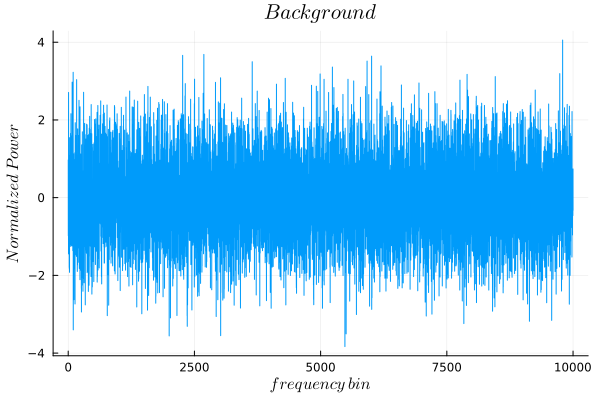

In [5]:
pcut=0.05
pass1=zeros(N_amplitude,N_width)
pass2=zeros(N_amplitude,N_width)
pass5=zeros(N_amplitude,N_width)
pass10=zeros(N_amplitude,N_width)

for n=1:N_amplitude
    amplitude[n]=Int(amplitude[n])
end

for i=1:N_amplitude
    for j=1:N_width
        for k=1:n_tests
            if (pv1[i,j,k]<pcut) pass1[i,j]+=1/n_tests            end
            if (pv2[i,j,k]<pcut) pass2[i,j]+=1/n_tests            end
            if (pv5[i,j,k]<pcut) pass5[i,j]+=1/n_tests            end
            if (pv10[i,j,k]<pcut) pass10[i,j]+=1/n_tests            end
        end
    end
end
#
# Print out results - different tables for different bin groupings
#
# Bin size=1

open("Passpcut_MB.txt","w") do io
println(io,"\\begin{table}")
println(io,"\\centering")
println(io,"\\begin{tabular}{cccccccc}")
println(io,"\\hline")
println(io," A & BinSize & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ & \$\\sigma_{\\rm sig}\$ \\\\")
println(io," & "," & ",width[1]," & ",width[2]," & ",width[3]," & ",width[4]," & ",width[5]," & ",width[6],"\\\\")
println(io,"\\hline")
for n=1:N_amplitude
    println(io,Int(amplitude[n])," & ",1," & ",round(pass1[n,1], sigdigits=2)," & ",round(pass1[n,2], sigdigits=2)," & ",
            round(pass1[n,3], sigdigits=2)," & ",round(pass1[n,4], sigdigits=2)," & ",
            round(pass1[n,5], sigdigits=2)," & ",round(pass1[n,6], sigdigits=2),"\\\\")
    println(io,Int(amplitude[n])," & ",2," & ",round(pass2[n,1], sigdigits=2)," & ",round(pass2[n,2], sigdigits=2)," & ",
            round(pass2[n,3], sigdigits=2)," & ",round(pass2[n,4], sigdigits=2)," & ",
            round(pass2[n,5], sigdigits=2)," & ",round(pass2[n,6], sigdigits=2),"\\\\")    
    println(io,Int(amplitude[n])," & ",5," & ",round(pass5[n,1], sigdigits=2)," & ",round(pass5[n,2], sigdigits=2)," & ",
            round(pass5[n,3], sigdigits=2)," & ",round(pass5[n,4], sigdigits=2)," & ",
            round(pass5[n,5], sigdigits=2)," & ",round(pass5[n,6], sigdigits=2),"\\\\")    
    println(io,Int(amplitude[n])," & ",10," & ",round(pass10[n,1], sigdigits=2)," & ",round(pass10[n,2], sigdigits=2)," & ",
            round(pass10[n,3], sigdigits=2)," & ",round(pass10[n,4], sigdigits=2)," & ",
            round(pass10[n,5], sigdigits=2)," & ",round(pass10[n,6], sigdigits=2),"\\\\")
    println(io,"\\hline")
end
println(io,"\\hline")
println(io,"\\end{tabular}")
println(io,"\\caption{The fraction of trials passing the \$p\\leq 0.05\$ cut. The first column gives the amplitude,\$A\$, of the input signal.  
        The second column give the width of the bins in which power is measured, and the succeeding columns
        give the width of the input signal \$\\sigma_{\\rm sig}\$ . }")
println(io,"\\label{tab:Pass}")
println(io,"\\end{table}")
end

using Plots
#
# Make some useful plots
#
using LaTeXStrings
Random.seed!(1234);
Run=randn(nbins)

p1=plot(Run,lw=1,legend=:none,xlabel=L"frequency \; bin", ylabel=L"Normalized \; Power",title=L"Background")


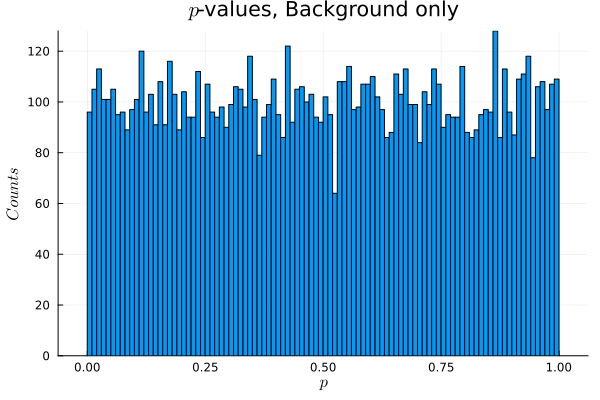

In [22]:
# 
# As a sanity check, we see if the p-value distribution is flat for background only
#
Random.seed!(1234);

nsanity=10000
pv=zeros(nsanity)
for i=1:nsanity
    Run=randn(nbins)
    Squares=t_obs(Run, 0., 1.)
    pv[i] = squares_pvalue_approx(Squares[1],Ns1, epsp)
end
p1=histogram(pv,bins=100,legend=:none,xlabel=L"$p$", ylabel=L"Counts",title=L"$p$-values, Background only")

In [23]:
pv , Squares

([0.11603050397138204, 0.586455788048177, 0.4002702162423437, 0.8281234968121648, 0.7991282857278892, 0.8731459114204969, 0.8308925135786969, 0.3906011941960873, 0.013567149380289578, 0.42159773972135883  …  0.15881968610306463, 0.45318233622650206, 0.9724020814622492, 0.4323990717962404, 0.24684119491882428, 0.039964740842229896, 0.3368905916430075, 0.3326618455648118, 0.049994450501855026, 0.42125672410364157], (21.394475760835988, [6428, 6429, 6430, 6431, 6432, 6433, 6434]))

(21.394475760835988, [6428, 6429, 6430, 6431, 6432, 6433, 6434])


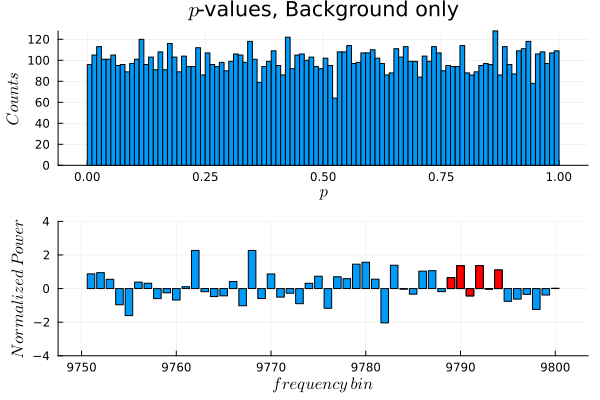

In [12]:
Squares=t_obs(Run, 0., 1.)
println(Squares)
pv = squares_pvalue_approx(Squares[1],Ns1, epsp)
plot(9751:9800,Run[9751:9800],lw=1,seriestype=:bar,legend=:none,xlabel=L"frequency \; bin", ylabel=L"Normalized \; Power",ylims=(-4.,4.))
p2=plot!(9789:9794,Run[9789:9794],lw=1,seriestype=:bar,legend=:none,color="red")
plot(p1,p2,layout=(2,1))

In [27]:
# Now add a substantial signal and see the distorted p-value distribution

Run1=zeros(nbins)
A=18
w=4
ds = Normal(0.,w)
pvs=zeros(nsanity)

for i=1:nsanity
    for bin=1:nbins
        x1=(bin-1) - nbins/2
        x2=bin - nbins/2
        
        bin_integral=signal_integral(x1, x2, A, w, :maxwell)
#
        d = Normal(bin_integral,1.)
        Run1[bin]=rand(d)
    end       
    Squares=t_obs(Run1, 0., 1.)
    pvs[i] = squares_pvalue_approx(Squares[1],Ns1, epsp)
end

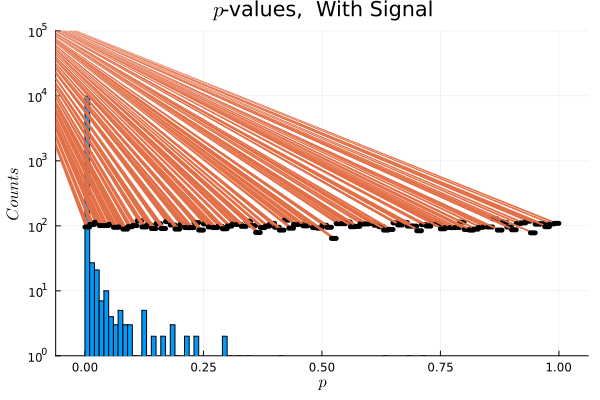

In [28]:
p3=histogram(pvs,bins=100,yaxis=:log10,ylims=(1,100000),legend=:none,xlabel=L"$p$", ylabel=L"Counts",title=L"$p$-values,  With Signal")
p3=histogram!(pv,bins=100,colow="red",xlabel=L"$p$", ylabel=L"Counts",lw=5)
